In [1]:
import pandas as pd
import numpy as np

from sklearn.datasets import make_classification
import statsmodels.discrete.discrete_model as sm

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('ggplot')
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 20,10

# Feature Importance Analysis
## P-Value Caveats Demonstrations
P-Values has the following pitfalls:
- Rely on many strong assumptions
- Produces noisy estimates
- Is a probability of something we don't need: Given $H_0$ and an estimated $\hat{\beta}$, p-values
estimates the probability of obtaining a result equal or more extreme than $\hat{\beta}$, subject to $H_0$ being true.
We are more interested in the probability of $H_0$ being true given an observed $\hat{\beta}$
- Not generalizable out of sample

In [2]:
def get_test_data(n_features=100, n_informative=25, n_redundant=25,
                  n_samples = 10000, random_state = 0, sigma_std = .0):
    """
    Generates a random
    :param n_features: Total number of features
    :type n_features: int
    :param n_informative: Number of informative features (subset of the features)
    :type n_informative: int
    :param n_redundant: Number of redundant features (subset of features)
    :type n_redundant: int
    :param n_samples: samples number
    :type n_samples: int
    :param random_state: random state
    :type random_state: float
    :param sigma_std: standard deviation
    :type sigma_std: float
    :return:  X : Dataframe of the generated samples.
              y : Series of the integer labels for class membership of each sample.
    :rtype: (pd.DataFrame, pd.Series)
    """
    np.random.seed(random_state)

    X,y = make_classification(
        n_samples=n_samples, n_features=n_features-n_redundant, n_informative=n_informative,
        n_redundant=0, shuffle=False, random_state=random_state
    )

    cols = [f'I_{i}' for i in range(n_informative)]
    cols += [f'N_{i}' for i in range(n_features - n_informative - n_redundant)]
    X = pd.DataFrame(X, columns=cols)
    y = pd.Series(y)
    i = np.random.choice(range(n_informative), size=n_redundant)
    for k, j in enumerate(i):
        X[f'R_{k}'] = X[f'I_{j}'] + np.random.normal(size=X.shape[0]) * sigma_std

    return X,y

In [3]:
X, y = get_test_data(
    n_features=40, n_informative=5, n_redundant=30, n_samples=10000,
    sigma_std=0.1
)

ols = sm.Logit(y, X).fit()


Optimization terminated successfully.
         Current function value: 0.380271
         Iterations 7


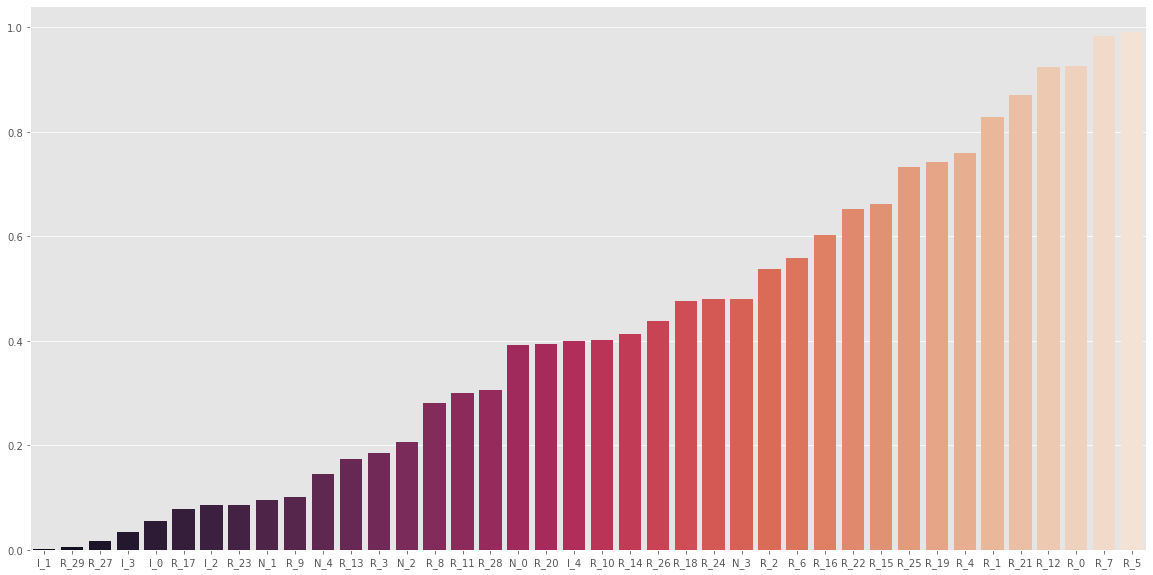

In [4]:
# Generate some sequential data
pvalues_sorted = ols.pvalues.sort_values()
sns.barplot(x=pvalues_sorted.index, y=pvalues_sorted.values, palette="rocket")

- Only four out of the thirty five non-noise features are deemed statistically significant : I_1, R_29, R_27, I_3.
- Noise features are ranked as relatively important
- Fourteen of the features ranked as least important are not noise

## Feature Importance: Mean-Decrease Impurity

In [5]:
def feat_imp_mdi(fit, feat_names):
    """
    Feature importance beased on IS mean impurity reduction
    :param fit:
    :type fit:
    :param feat_names:
    :type feat_names:
    :return:
    :rtype:
    """
    df0 = {
        i: tree.feature_importances_ for i, tree in enumerate(fit.estimators_)
    }
    df0 = pd.DataFrame.from_dict(df0, orient="index")
    df0.columns = feat_names
    df0 = df0.replace(0, np.nan) # beacause max_features=1

    imp = pd.concat(
        {
            'mean': df0.mean(),
            'std': df0.std() * df0.shape[0]**-.5
        },
        axis=1
    )

    imp /= imp['mean'].sum()
    return imp

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

X, y = get_test_data(
    n_features=40, n_informative=5, n_redundant=30, n_samples=10000,
    sigma_std=0.1
)

clf = DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    class_weight='balanced',
    min_weight_fraction_leaf=0
)

clf = BaggingClassifier(base_estimator=clf, n_estimators=1000,
                        max_features=1., max_samples=1.)

fit = clf.fit(X,y)

imp = feat_imp_mdi(fit, feat_names=X.columns).sort_values(by=['mean'])


<ErrorbarContainer object of 3 artists>

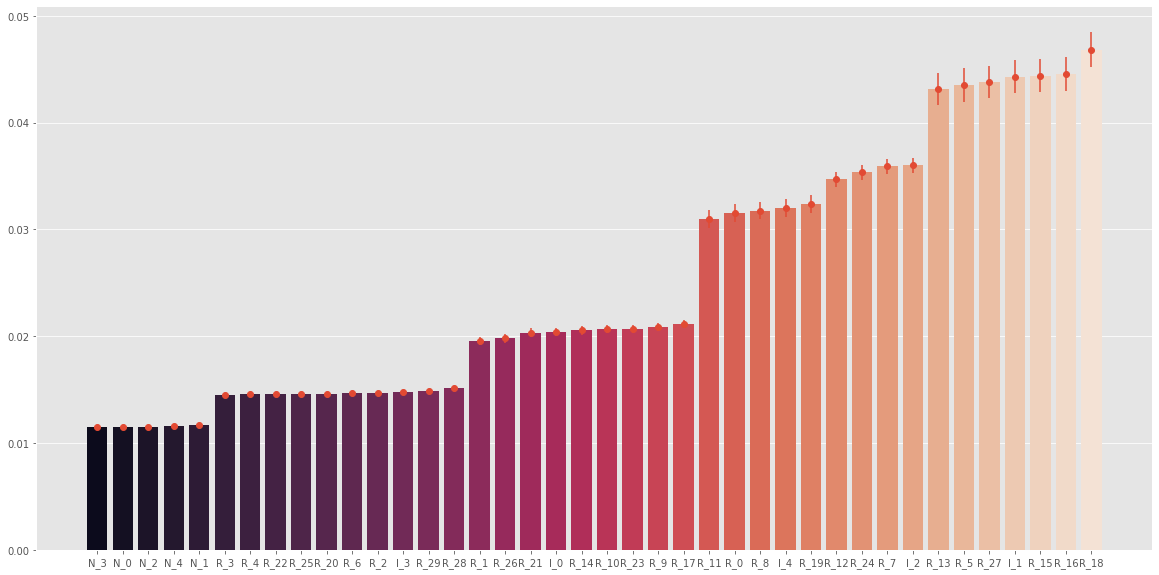

In [30]:
ax = sns.barplot(x=imp.index, y=imp['mean'].values, palette="rocket")
ax.errorbar(imp.index, imp['mean'], yerr=imp['std'], ls='none', fmt='-o')

- MDI does a good job as noisy features are less important
- A small number of nonnoisy features appear to be much more important than their peers (substitution effect)

Out of the 4 p-values pitfalls, the MDI method deals with three: 
- No need for strong distributional assumptions
- Variance of MDI estimates can be reduced by increasing the number of trees in ensemble methods in general or random forest in particular -> less noisy results 
- The goal of the the tree-based classifiers is not to estimate the coefficients of a given algebraic equation. Estimating the probability of 
